In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

plt.rcParams["figure.figsize"] = (10, 10)

In [60]:
VERBOSE = 0
N_JOBS = 4

In [61]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.bsvclassifier import BSVClassifier

# Evaluation

Article Source: A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data 
Goldstein M, Uchida S (2016) A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data. PLOS ONE 11(4): e0152173. https://doi.org/10.1371/journal.pone.0152173

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

I'm going to test the following dataset:
1. Pen-Global
1. Pen-Local
1. Speech
1. Aloi

On the following metrics: ROC-AUC

## Pen-Global Dataset

Paper version: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/OPQMVF/KQYDN9&version=1.0

Original UCI: https://archive.ics.uci.edu/ml/datasets/Pen-Based%20Recognition%20of%20Handwritten%20Digits

In [62]:
input_names = []

for i in range(8):
    input_names.append(f'x{i}')
    input_names.append(f'y{i}')

data = pd.read_csv('/Users/maxfrax/Downloads/pen-global-unsupervised-ad.csv', names=input_names+['outlier'])
data = data.sample(frac=1)

In [63]:
data

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,outlier
779,66.0,48.0,100.0,82.0,52.0,100.0,39.0,64.0,79.0,29.0,43.0,0.0,0.0,26.0,59.0,56.0,n
479,32.0,85.0,67.0,55.0,95.0,10.0,4.0,0.0,12.0,40.0,95.0,71.0,100.0,100.0,0.0,87.0,n
168,47.0,69.0,42.0,100.0,6.0,75.0,54.0,39.0,47.0,0.0,0.0,21.0,42.0,58.0,100.0,90.0,n
295,35.0,86.0,56.0,65.0,100.0,27.0,23.0,0.0,6.0,28.0,65.0,64.0,98.0,100.0,0.0,85.0,n
270,67.0,99.0,0.0,95.0,29.0,61.0,100.0,36.0,87.0,0.0,43.0,21.0,70.0,60.0,83.0,100.0,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,65.0,60.0,100.0,100.0,5.0,100.0,19.0,57.0,65.0,15.0,0.0,0.0,13.0,43.0,97.0,75.0,n
625,82.0,83.0,39.0,100.0,10.0,64.0,71.0,33.0,72.0,0.0,0.0,10.0,42.0,48.0,100.0,82.0,n
497,49.0,49.0,100.0,79.0,54.0,100.0,8.0,68.0,35.0,27.0,0.0,0.0,6.0,35.0,71.0,63.0,n
745,9.0,41.0,73.0,80.0,0.0,100.0,28.0,56.0,92.0,16.0,35.0,0.0,22.0,42.0,100.0,74.0,n


In [64]:
X = data[input_names]
y = data['outlier'] == 'o'

y = np.array([-1 if v else 1 for v in y])

### Dimensionality Reduction

In [65]:
from sklearn.manifold import TSNE

X = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)

/Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


### Normalization

In the paper the declare they scale all their datasets with MinMax (Normalization section)

In [66]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

In [67]:
X.shape

(809, 2)

Plot all points after dimensionality reduction:

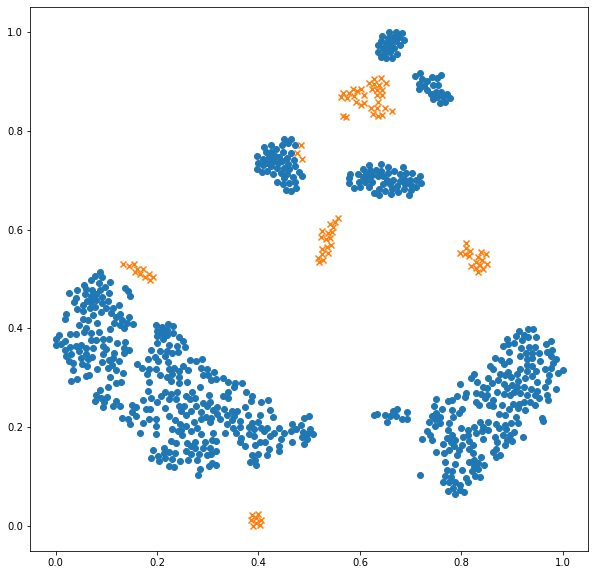

In [68]:
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==-1,0], X[y==-1,1], marker='x')
plt.show()

### Replicating: One Class SVM

I'm going to use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html since both the paper and sklearn refer to:

Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.

In the paper they use OneClassSVM in an unsupervised setting.

> In the unsupervised anomaly detection scenario, the one-class SVM is trained using the dataset and afterwards, each instance in the dataset is scored by a normalized distance to the determined decision boundary [40]. The parameter ν needs to be set to a value lager than zero such that the contained anomalies are correctly handled by a soft-margin

The hyper parameters tested are 0.2 < v < 0.8 and automatic tuning for the Gaussian kernel.
By automatic tuning I guess they talk about trial and error. In fact they declare it as a computationally hard task.

In [69]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [70]:
def svm_experiment(classifier, distributions, metric: str):
    print(f'One Class Experiment: {metric}')

    # Gamma is a free parameter. It ranges from 0 to infinity
    # Predefined split to train on the whole dataset and test on the whole dataset
    test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

    search = RandomizedSearchCV(classifier, distributions, cv=PredefinedSplit(test_fold=test_fold), refit=True, n_iter=100, scoring='average_precision', n_jobs=N_JOBS, error_score='raise', verbose=VERBOSE)

    res = search.fit(np.concatenate([X,X]), np.concatenate([y,y]))

    clf = res.best_estimator_

    print(res.best_index_)
    print(res.best_score_)
    print(res.best_params_)


    y_pred = clf.predict(X)

    conf_mat = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_mat).plot()
    plt.show()

    display(conf_mat)

    RocCurveDisplay.from_predictions(y, clf.score_samples(X))

    plt.show()

    PrecisionRecallDisplay.from_predictions(y, clf.score_samples(X))

    plt.show()

    cv_results = pd.DataFrame(res.cv_results_)
    cv_results.sort_values('rank_test_score')

    print(f"Average Score: {np.average(cv_results['mean_test_score'])}")
    print(f"STD Score: {np.std(cv_results['mean_test_score'])}")

    if isinstance(clf, BSVClassifier):
        clf.plot()

One Class Experiment: average_precision
34
0.9332631926795358
{'gamma': 4.467518647486321, 'nu': 0.9858695066706187}


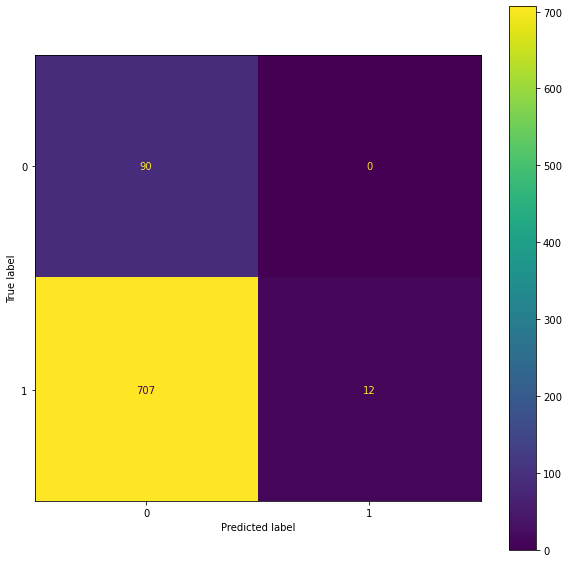

array([[ 90,   0],
       [707,  12]])

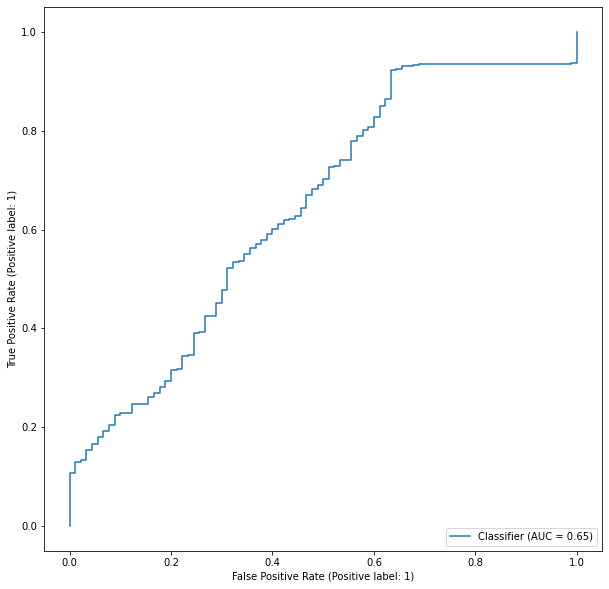

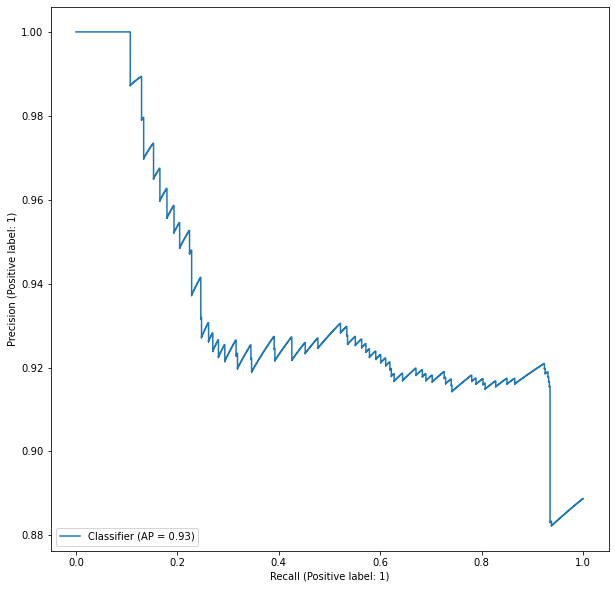

Average Score: 0.8731938341906428
STD Score: 0.017203023344595305


In [71]:
classifier = OneClassSVM(kernel='rbf')
distributions = dict(nu=uniform(loc=0.2, scale=0.8), gamma=uniform(loc=0, scale=5))

# DEBUG
#svm_experiment(classifier, distributions, 'roc_auc')
svm_experiment(classifier, distributions, 'average_precision')

### My Algorithm: BSVClassifier

In [72]:
classifier = BSVClassifier(normal_class_label=1, outlier_class_label=-1)
distributions = {'c':uniform(loc=0.2, scale=0.8),'q':uniform(loc=0, scale=5)}

# DEBUG
#svm_experiment(classifier, distributions, 'roc_auc')
#svm_experiment(classifier, distributions, 'average_precision')

### Federated Learning: BSVClassifier

The whole work is inspired by https://arxiv.org/pdf/1602.05629.pdf paper.

Since we are working in an unsupervised setting, our metric is not Accuracy but Roc-Auc.

We will not use E, number of iterations per client update, since we are doing exact calculation and not gradient descent.
Same thing with the parameter B

In [73]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.federatedbsvclassifier import FederatedBSVClassifier

#### IID

We have about **809 samples**. 
Let's sort them and distribute them among **10 clients**.

There are 9 points that will be randomly left over.

In [74]:
total_clients = 10

data_per_client = int(len(X)/total_clients)

X = X[0:data_per_client*total_clients]
y = y[0:data_per_client*total_clients]

client_assignment = []

# Split the data among the clients in a balanced way
for i in range(total_clients):
    client_assignment.extend([i]*data_per_client)

client_assignment = np.array(client_assignment)

print(f'len Client assignment {len(client_assignment)} == len X {len(X)}')

len Client assignment 800 == len X 800


In [75]:
# Inputs
# C: 0 aka 1 client, .1, .2, .5, 1 aka total_clients
# B: 'infinite' aka data_per_client, 1% of data_per_client

parameters = {
'client_fraction': [.1, .5,  1],
'max_rounds': [1, 3, 5],
'B': [5, 10]
}

test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res_iid = search.fit(np.concatenate([X,X]), np.concatenate([y,y]), client_assignment=np.concatenate([client_assignment, client_assignment]))

iid_clf = res_iid.best_estimator_

print(res_iid.best_index_)
print(res_iid.best_score_)
print(res_iid.best_params_)


y_pred = iid_clf.predict(X)

Round 0 of 0
Selected clients [4]
Round 0 of 0
Selected clients [0]
Round 0 of 2
Selected clients [4]
Round 1 of 2
Selected clients [2]
Round 2 of 2
Selected clients [4]
Round 0 of 2
Selected clients [0]
Round 1 of 2
Selected clients [0]
Round 2 of 2
Selected clients [0]
Round 0 of 4
Selected clients [7]
Round 1 of 4
Selected clients [8]
Round 2 of 4
Selected clients [1]
Round 3 of 4
Selected clients [3]
Round 4 of 4
Selected clients [0]
There is no client 0 update. No betas far from zero among all the 4 points
Round 0 of 4
Selected clients [6]
Round 1 of 4
Selected clients [4]
Round 2 of 4
Selected clients [6]
Round 3 of 4
Selected clients [8]
Round 4 of 4
Selected clients [7]
Round 0 of 0
Selected clients [8 3 6 9 5]
Round 0 of 0
Selected clients [7 5 8 2 4]
Round 0 of 2
Selected clients [4 8 7 6 3]
Round 1 of 2
Selected clients [8 4 1 9 2]
Round 2 of 2
Selected clients [1 3 2 6 4]
There is no client 1 update. No betas far from zero among all the 5 points
There is no client 4 update.

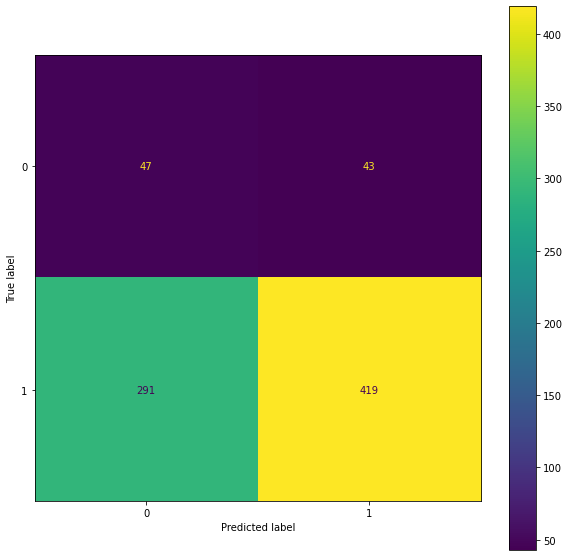

array([[ 47,  43],
       [291, 419]])

In [76]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

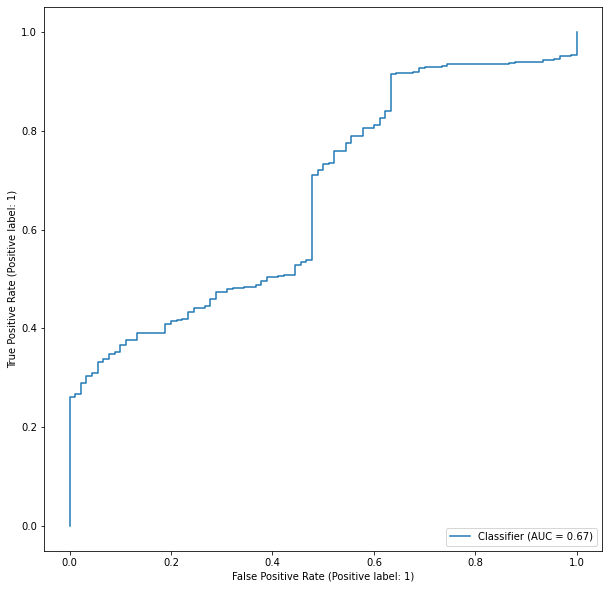

In [77]:
RocCurveDisplay.from_predictions(y, iid_clf.score_samples(X))

plt.show()

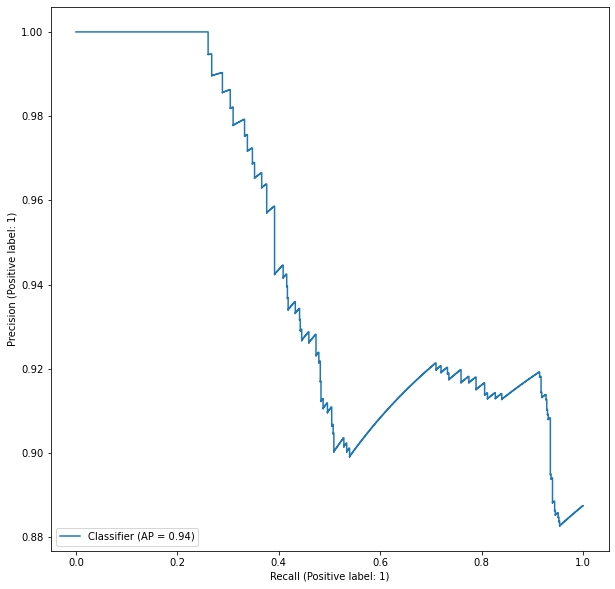

In [78]:
PrecisionRecallDisplay.from_predictions(y, iid_clf.score_samples(X))

plt.show()

In [79]:
iid_cv_results = pd.DataFrame(res_iid.cv_results_)

iid_cv_results['Datapoints Estimate'] = iid_cv_results['param_B'] * iid_cv_results['param_client_fraction'] * total_clients * iid_cv_results['param_max_rounds']

iid_cv_results = iid_cv_results.sort_values('rank_test_score')

iid_cv_results.to_csv('iid_cv_results.csv')

iid_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,Datapoints Estimate
0,1.576790,1.509075,0.045990,0.010930,5,0.1,1,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 1}",0.950101,0.825542,0.887822,0.062280,1,5.0
3,0.250422,0.003821,0.234159,0.006894,5,0.5,1,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 1}",0.815136,0.918034,0.866585,0.051449,2,25.0
1,0.249328,0.047633,0.099973,0.021440,5,0.1,3,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 3}",0.877225,0.835259,0.856242,0.020983,3,15.0
9,0.108020,0.018334,0.105694,0.016589,10,0.1,1,"{'B': 10, 'client_fraction': 0.1, 'max_rounds'...",0.837401,0.831490,0.834445,0.002955,4,10.0
6,0.565382,0.020777,0.422377,0.009814,5,1,1,"{'B': 5, 'client_fraction': 1, 'max_rounds': 1}",0.832083,0.831974,0.832028,0.000055,5,50
5,0.796504,0.004419,0.138335,0.015861,5,0.5,5,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 5}",0.824669,0.829347,0.827008,0.002339,6,125.0
7,1.066475,0.002504,0.123352,0.033227,5,1,3,"{'B': 5, 'client_fraction': 1, 'max_rounds': 3}",0.832256,0.818765,0.825510,0.006746,7,150
10,0.324963,0.040747,0.138509,0.037544,10,0.1,3,"{'B': 10, 'client_fraction': 0.1, 'max_rounds'...",0.833017,0.815435,0.824226,0.008791,8,30.0
14,1.010966,0.101324,0.095568,0.016637,10,0.5,5,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.822306,0.823557,0.822931,0.000625,9,250.0
8,1.393786,0.069230,0.106940,0.005615,5,1,5,"{'B': 5, 'client_fraction': 1, 'max_rounds': 5}",0.824284,0.821239,0.822762,0.001523,10,250


In [80]:
print(np.average(iid_cv_results['mean_test_score']))
print(np.std(iid_cv_results['mean_test_score']))

0.8301010276559986
0.019454606641950214


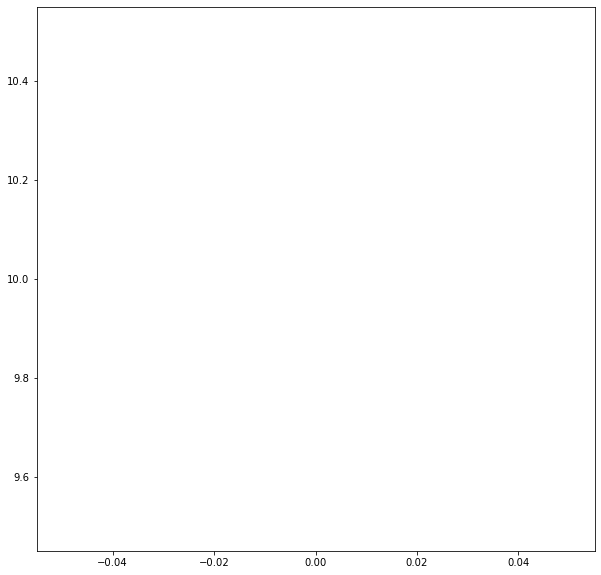

In [81]:
plt.plot(iid_clf.sv_count)
plt.show()

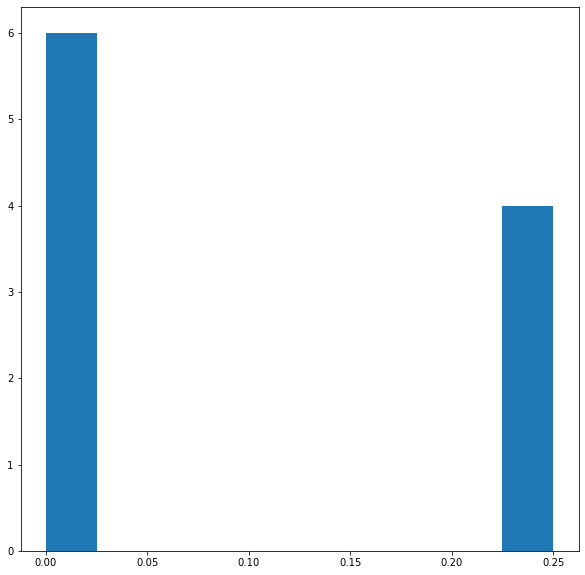

In [82]:
plt.hist(iid_clf.clf.betas_)
plt.show()

In [83]:
display(pd.DataFrame(iid_cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
5,0.839107
10,0.821095


,mean_test_score
param_B,
5,0.025224
10,0.005729


,mean_test_score
param_client_fraction,
0.1,0.840651
0.5,0.826845
1.0,0.822807


,mean_test_score
param_client_fraction,
0.1,0.026773
0.5,0.020182
1.0,0.005322


,mean_test_score
param_max_rounds,
1,0.842355
3,0.825636
5,0.822311


,mean_test_score
param_max_rounds,
1,0.028813
3,0.015755
5,0.002688


,param_client_fraction,param_max_rounds,Mean,Std,Scaled Std
0,0.1,1,0.861133,0.037743,377.427464
3,0.5,1,0.840959,0.036240,362.399478
1,0.1,3,0.840234,0.022639,226.389388
6,1.0,1,0.824973,0.009978,99.776286
5,0.5,5,0.824970,0.002883,28.828878
7,1.0,3,0.822069,0.004866,48.661327
8,1.0,5,0.821379,0.001955,19.546032
2,0.1,5,0.820585,0.001471,14.706101
4,0.5,3,0.814606,0.003145,31.452733


<Figure size 720x720 with 0 Axes>

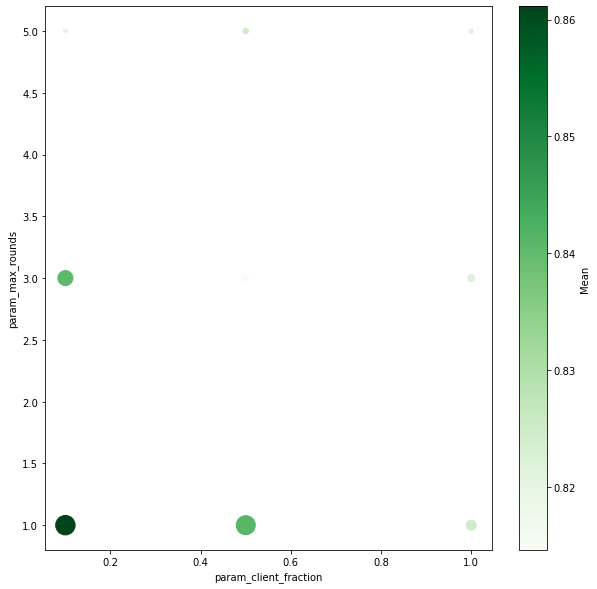

,param_client_fraction,param_B,Mean,Std,Scaled Std
0,0.1,5,0.855230,0.033110,331.098071
2,0.5,5,0.835325,0.028042,280.423846
4,1.0,5,0.826767,0.004760,47.595331
1,0.1,10,0.826072,0.007620,76.195990
5,1.0,10,0.818848,0.001057,10.568573
3,0.5,10,0.818365,0.004025,40.245538


<Figure size 720x720 with 0 Axes>

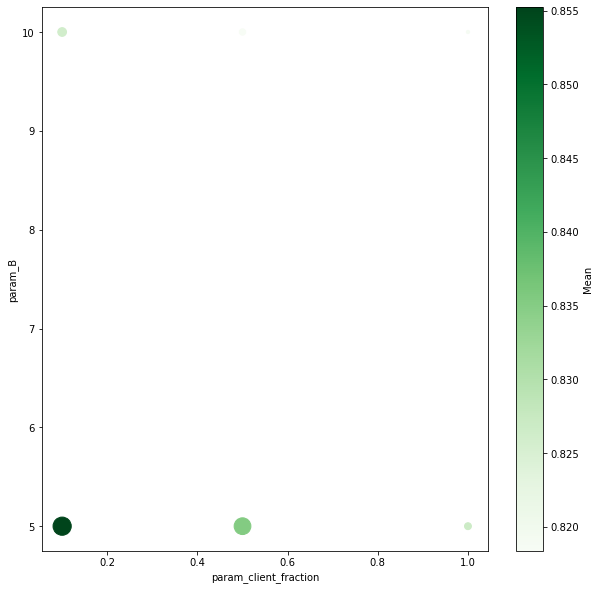

,param_max_rounds,param_B,Mean,Std,Scaled Std
0,1,5,0.862145,0.028160,281.602802
2,3,5,0.831378,0.022511,225.112255
4,5,5,0.823798,0.002837,28.372746
1,1,10,0.822566,0.010369,103.688136
5,5,10,0.820825,0.001838,18.382112
3,3,10,0.819895,0.003857,38.571250


<Figure size 720x720 with 0 Axes>

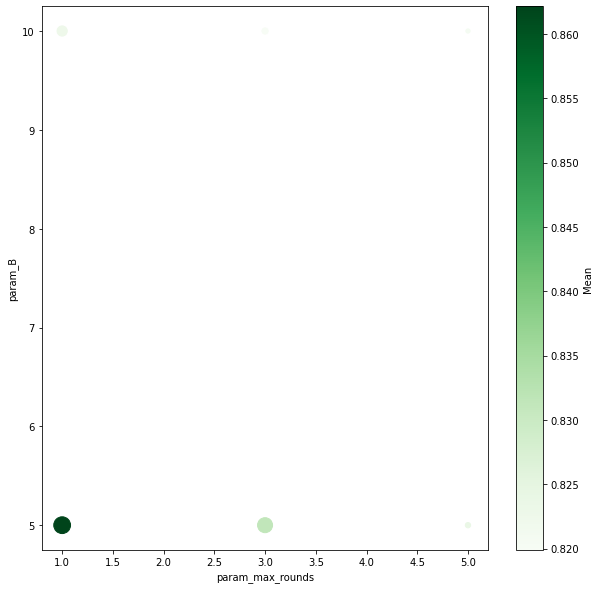

In [84]:
scale_factor = 10000

# Plot 1
plot1_data = pd.DataFrame(iid_cv_results.groupby(['param_client_fraction', 'param_max_rounds']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot1_data.sort_values(by='Mean', ascending=False, inplace=True)
plot1_data['Scaled Std'] = plot1_data['Std'] * scale_factor
display(plot1_data)

fig = plt.figure()
ax1 = plot1_data.plot.scatter(x='param_client_fraction', y='param_max_rounds', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

# Plot 2
plot2_data = pd.DataFrame(iid_cv_results.groupby(['param_client_fraction', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot2_data.sort_values(by='Mean', ascending=False, inplace=True)
plot2_data['Scaled Std'] = plot2_data['Std'] * scale_factor
display(plot2_data)

fig = plt.figure()
ax2 = plot2_data.plot.scatter(x='param_client_fraction', y='param_B', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

# Plot 3
plot3_data = pd.DataFrame(iid_cv_results.groupby(['param_max_rounds', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot3_data.sort_values(by='Mean', ascending=False, inplace=True)
plot3_data['Scaled Std'] = plot3_data['Std'] * scale_factor
display(plot3_data)

fig = plt.figure()
ax3 = plot3_data.plot.scatter(x='param_max_rounds', y='param_B', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

In [85]:
def plot_clf(clf, ix, X=None, y=None):

    color = colormaps['tab10'](ix)

    if X is None or y is None:
        X = clf.X_
        y = clf.y_ 

    gx = np.linspace(0, 1)
    gy = np.linspace(0, 1)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radius_, ), colors=[color])
    plt.clabel(membership_contour, inline=1)

    plt.scatter(X[y==1,0], X[y==1,1],  color=color, label=str(ix))
    plt.scatter(X[y==-1,0], X[y==-1,1], marker='x', color=color, label=str(ix))

def plot_fbsv(fbsv):
    frames = []
    #Plot client assignment
    plt.title('All the dataset colored by client assignment')
    plt.scatter(X[y==1,0], X[y==1,1], c=client_assignment[y==1])
    plt.scatter(X[y==-1,0], X[y==-1,1], marker='x', c=client_assignment[y==-1])
    plt.show()

    # Plot client training
    for round in fbsv.classifiers:
        plt.title(f'Round {round["round"]} - Clients training')
        for id, clf in round['clients'].items():
            plot_clf(clf, id)

        plt.legend()
        plt.show()
        plt.title(f'Round {round["round"]} - Global combine')
        plot_clf(round['global'], total_clients+1)
        plt.show()

    # Plot final classifier on the whole dataset
    plt.title("Whole dataset with final classifier")
    plot_clf(fbsv.clf, total_clients+2, X, y)
    plt.show()
    
    # Create animation of the training process

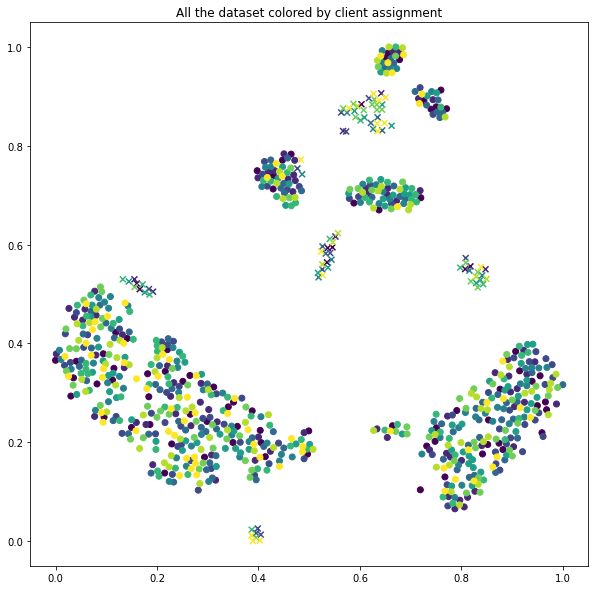

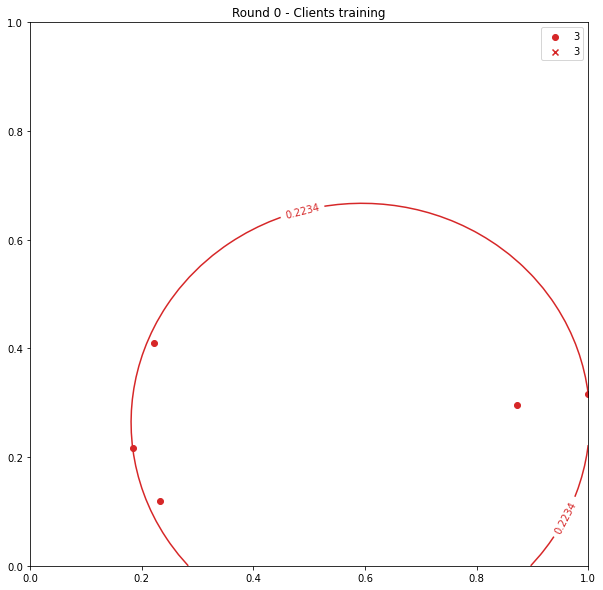

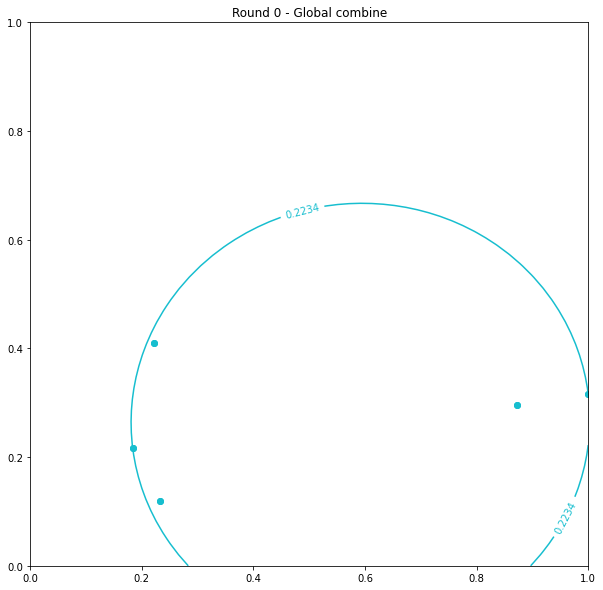

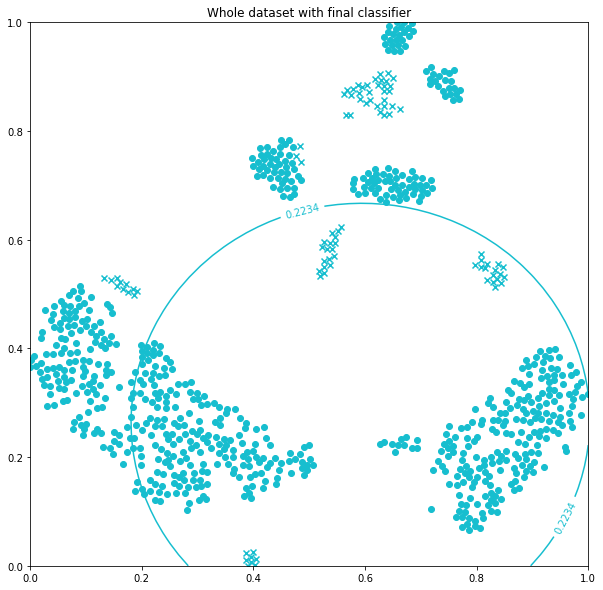

In [86]:
plot_fbsv(iid_clf)

#### Non IID

In [87]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=total_clients)
client_assignment = kmeans.fit_predict(X)

In [88]:
from collections import Counter
Counter(client_assignment)

Counter({5: 79,
         0: 114,
         2: 110,
         9: 96,
         7: 106,
         1: 71,
         6: 50,
         3: 79,
         4: 17,
         8: 78})

In [89]:
test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res_n_iid = search.fit(np.concatenate([X,X]), np.concatenate([y,y]), client_assignment=np.concatenate([client_assignment, client_assignment]))

n_iid_clf = res_n_iid.best_estimator_

print(res_n_iid.best_index_)
print(res_n_iid.best_score_)
print(res_n_iid.best_params_)


y_pred = n_iid_clf.predict(X)

Round 0 of 0
Selected clients [4]
Client 4 does not have normal class datapoints among the 5 points
No datapoints after combining global model and client update. Is everything okay?
Round 0 of 0
Selected clients [5]
Round 0 of 2
Selected clients [9]
Round 1 of 2
Selected clients [8]
Round 2 of 2
Selected clients [8]
Round 0 of 2
Selected clients [5]
Round 1 of 2
Selected clients [8]
Round 2 of 2
Selected clients [2]
Round 0 of 4
Selected clients [4]
Client 4 does not have normal class datapoints among the 5 points
No datapoints after combining global model and client update. Is everything okay?
Round 1 of 4
Selected clients [1]
Round 2 of 4
Selected clients [4]
There is no client 4 update. No betas far from zero among all the 0 points
Round 3 of 4
Selected clients [9]
Round 4 of 4
Selected clients [3]
Round 0 of 4
Selected clients [0]
Round 1 of 4
Selected clients [2]
Round 2 of 4
Selected clients [5]
Round 3 of 4
Selected clients [2]
Round 4 of 4
Selected clients [9]
Round 0 of 0
Sele

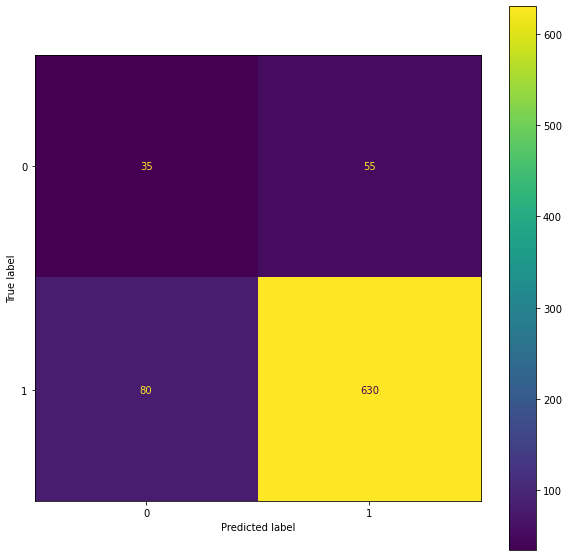

array([[ 35,  55],
       [ 80, 630]])

In [90]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

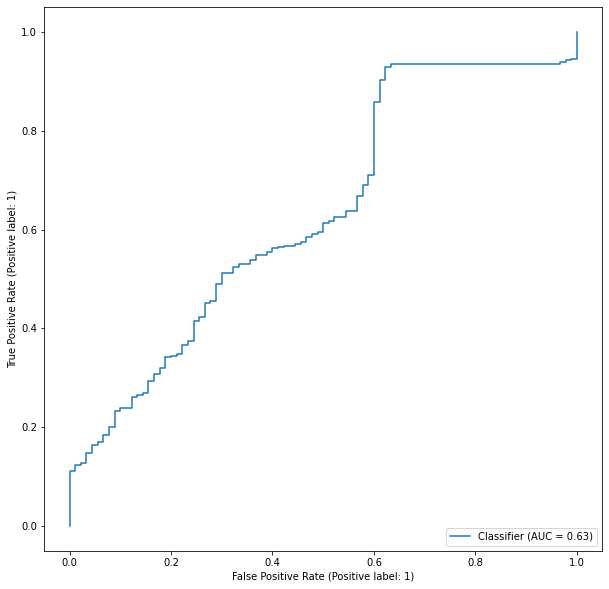

In [91]:
RocCurveDisplay.from_predictions(y, n_iid_clf.score_samples(X))

plt.show()

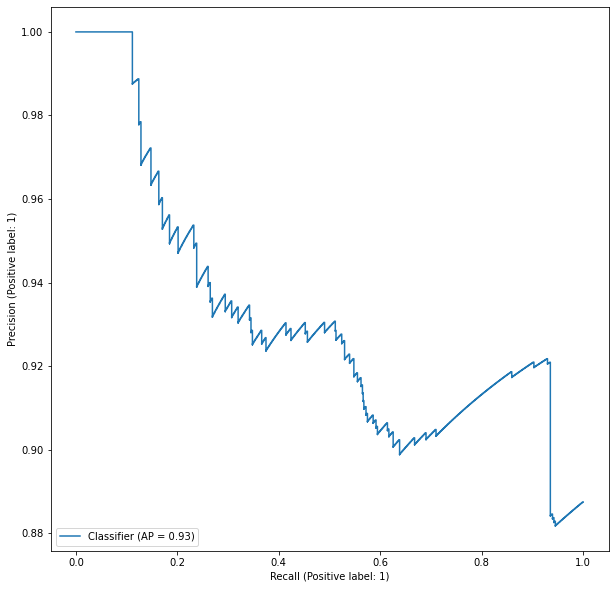

In [92]:
PrecisionRecallDisplay.from_predictions(y, n_iid_clf.score_samples(X))

plt.show()

In [93]:
n_iid_cv_results = pd.DataFrame(res_n_iid.cv_results_)

n_iid_cv_results['Datapoints Estimate'] = n_iid_cv_results['param_B'] * n_iid_cv_results['param_client_fraction'] * total_clients * n_iid_cv_results['param_max_rounds']

n_iid_cv_results = n_iid_cv_results.sort_values('rank_test_score')

n_iid_cv_results.to_csv('n_iid_cv_results.csv')

n_iid_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,Datapoints Estimate
12,0.333766,0.204929,0.272236,0.150929,10,0.5,1,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.955229,0.930883,0.943056,0.012173,1,50.0
4,0.492693,0.081583,0.100066,0.043383,5,0.5,3,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 3}",0.896233,0.931536,0.913884,0.017651,2,75.0
6,0.402970,0.026437,0.318412,0.005025,5,1,1,"{'B': 5, 'client_fraction': 1, 'max_rounds': 1}",0.909668,0.911769,0.910718,0.001050,3,50
15,0.668395,0.597348,0.349851,0.349124,10,1,1,"{'B': 10, 'client_fraction': 1, 'max_rounds': 1}",0.883368,0.929912,0.906640,0.023272,4,100
7,0.580592,0.279385,0.078251,0.011243,5,1,3,"{'B': 5, 'client_fraction': 1, 'max_rounds': 3}",0.946698,0.823492,0.885095,0.061603,5,150
9,0.100487,0.016978,0.099586,0.021459,10,0.1,1,"{'B': 10, 'client_fraction': 0.1, 'max_rounds'...",0.947841,0.813750,0.880795,0.067045,6,10.0
8,1.040218,0.168136,0.083887,0.016362,5,1,5,"{'B': 5, 'client_fraction': 1, 'max_rounds': 5}",0.926426,0.827421,0.876924,0.049502,7,250
1,0.260134,0.003134,0.099671,0.021446,5,0.1,3,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 3}",0.954228,0.796515,0.875372,0.078856,8,15.0
16,1.648880,0.402701,0.174250,0.074412,10,1,3,"{'B': 10, 'client_fraction': 1, 'max_rounds': 3}",0.903957,0.822989,0.863473,0.040484,9,300
0,0.051735,0.048103,0.035199,0.033823,5,0.1,1,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 1}",0.892428,0.817453,0.854940,0.037487,10,5.0


In [94]:
print(np.average(n_iid_cv_results['mean_test_score']))
print(np.std(n_iid_cv_results['mean_test_score']))

0.8619339678801174
0.038352664971530885


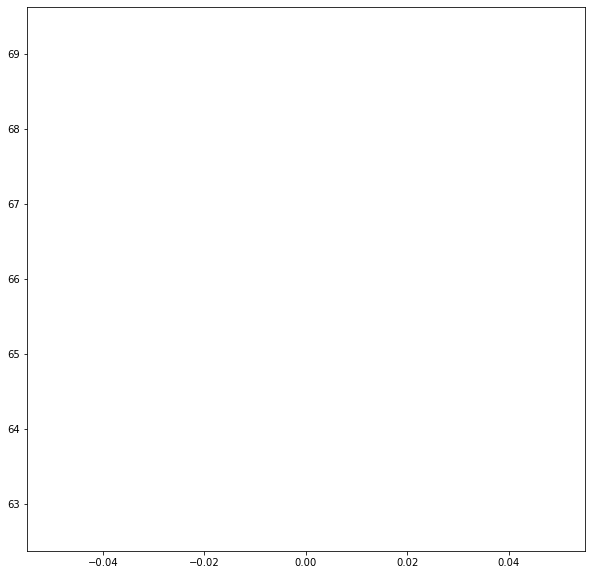

In [95]:
plt.plot(n_iid_clf.sv_count)
plt.show()

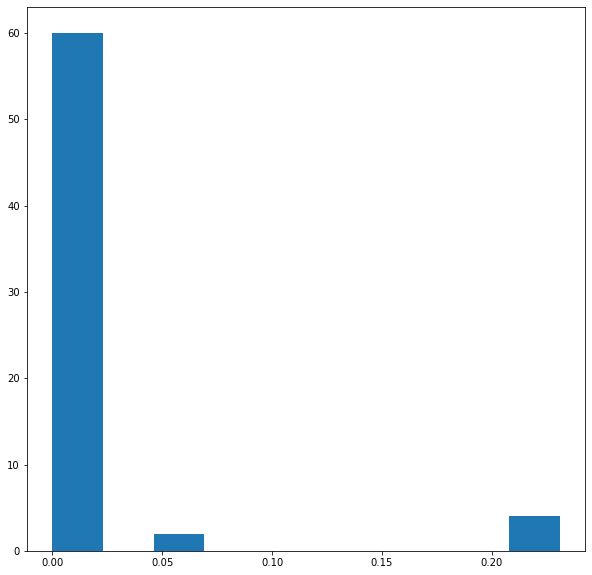

In [96]:
plt.hist(n_iid_clf.clf.betas_)
plt.show()

In [97]:
display(pd.DataFrame(n_iid_cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
5,0.867596
10,0.856272


,mean_test_score
param_B,
5,0.034186
10,0.045484


,mean_test_score
param_client_fraction,
0.1,0.851980
0.5,0.855932
1.0,0.877890


,mean_test_score
param_client_fraction,
0.1,0.023461
0.5,0.057219
1.0,0.031675


,mean_test_score
param_max_rounds,
1,0.884977
3,0.864790
5,0.836034


,mean_test_score
param_max_rounds,
1,0.045833
3,0.034841
5,0.022997


,param_client_fraction,param_max_rounds,Mean,Std,Scaled Std
6,1.0,1,0.908679,0.002884,28.838912
3,0.5,1,0.878384,0.091459,914.594215
7,1.0,3,0.874284,0.015289,152.889248
0,0.1,1,0.867868,0.018282,182.820721
4,0.5,3,0.867456,0.065659,656.594829
1,0.1,3,0.852631,0.032160,321.602401
8,1.0,5,0.850706,0.037077,370.767987
2,0.1,5,0.835441,0.018188,181.879353
5,0.5,5,0.821956,0.010547,105.472195


<Figure size 720x720 with 0 Axes>

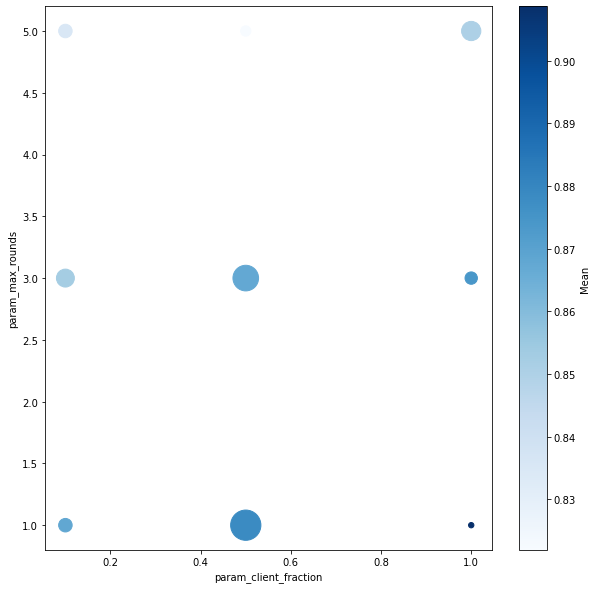

,param_client_fraction,param_B,Mean,Std,Scaled Std
4,1.0,5,0.890912,0.017632,176.324972
5,1.0,10,0.864867,0.041093,410.932023
0,0.1,5,0.859538,0.014108,141.081749
3,0.5,10,0.859527,0.072412,724.117824
2,0.5,5,0.852337,0.053877,538.765600
1,0.1,10,0.844422,0.031711,317.114754


<Figure size 720x720 with 0 Axes>

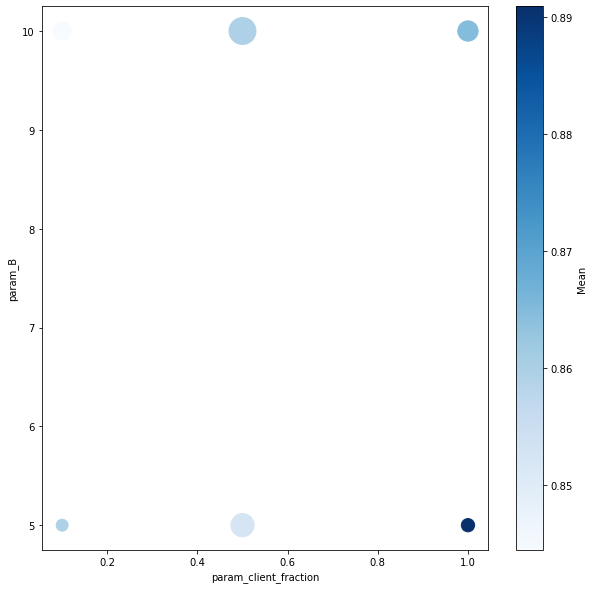

,param_max_rounds,param_B,Mean,Std,Scaled Std
1,1,10,0.910164,0.031280,312.796203
2,3,5,0.891450,0.020028,200.275066
0,1,5,0.859791,0.048684,486.842987
4,5,5,0.851547,0.023921,239.205158
3,3,10,0.838130,0.022390,223.902919
5,5,10,0.820522,0.005304,53.041420


<Figure size 720x720 with 0 Axes>

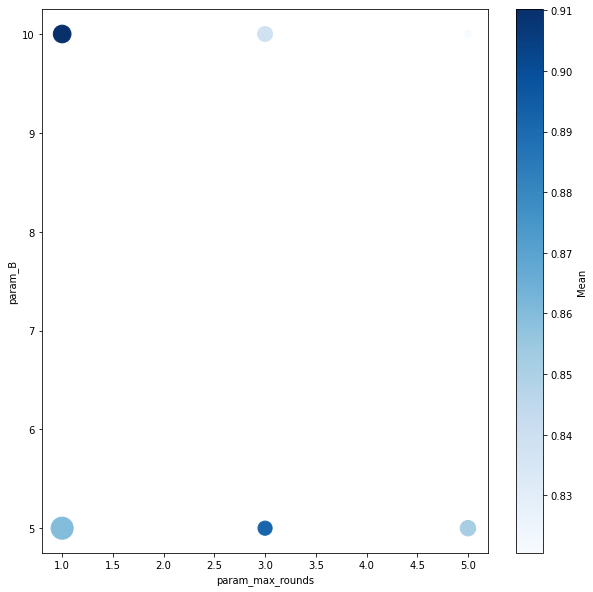

In [98]:
scale_factor = 10000

# Plot 1
plot1_data = pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction', 'param_max_rounds']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot1_data.sort_values(by='Mean', ascending=False, inplace=True)
plot1_data['Scaled Std'] = plot1_data['Std'] * scale_factor
display(plot1_data)

fig = plt.figure()
ax1 = plot1_data.plot.scatter(x='param_client_fraction', y='param_max_rounds', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()

# Plot 2
plot2_data = pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot2_data.sort_values(by='Mean', ascending=False, inplace=True)
plot2_data['Scaled Std'] = plot2_data['Std'] * scale_factor
display(plot2_data)

fig = plt.figure()
ax2 = plot2_data.plot.scatter(x='param_client_fraction', y='param_B', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()

# Plot 3
plot3_data = pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot3_data.sort_values(by='Mean', ascending=False, inplace=True)
plot3_data['Scaled Std'] = plot3_data['Std'] * scale_factor
display(plot3_data)

fig = plt.figure()
ax3 = plot3_data.plot.scatter(x='param_max_rounds', y='param_B', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()

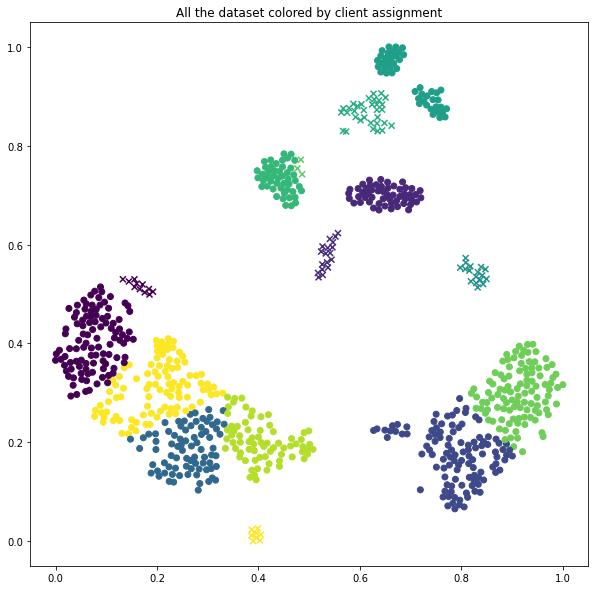

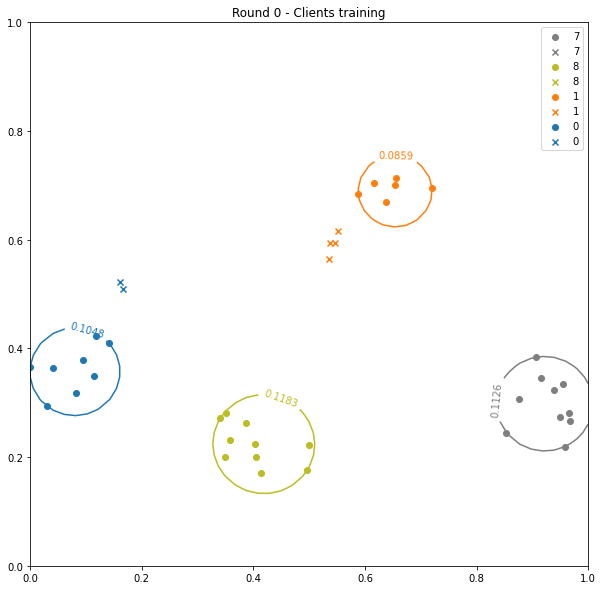

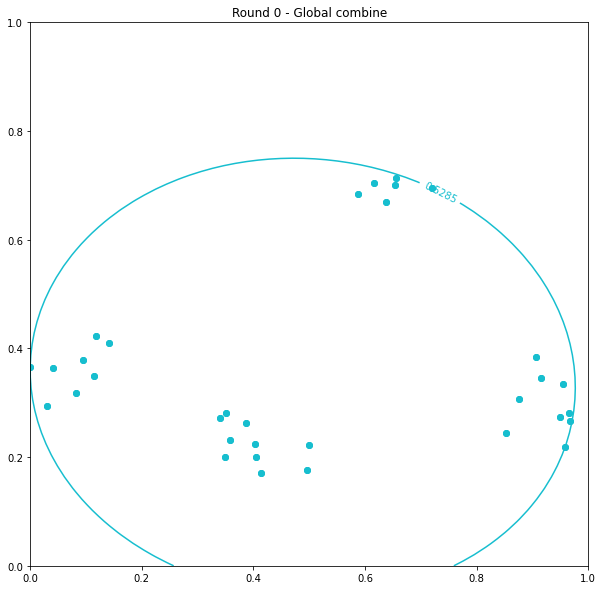

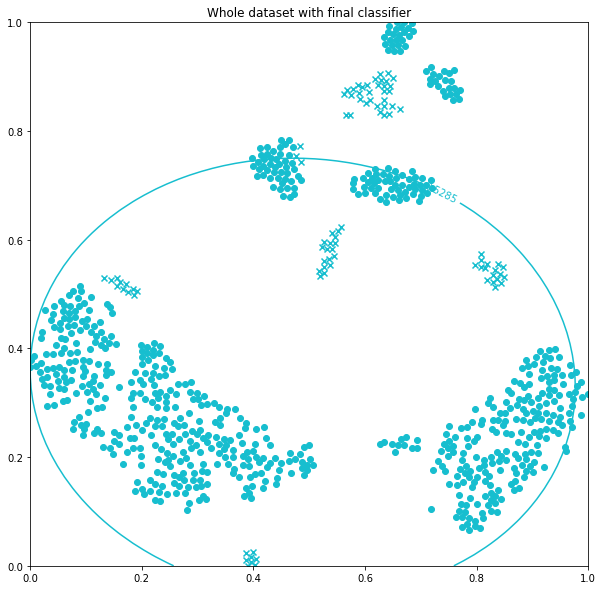

In [99]:
plot_fbsv(n_iid_clf)